<a href="https://colab.research.google.com/github/nick-allen21/synthetic_patient_analysis/blob/main/nallen21_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS145: Project 1 | Healthcare Provider/Payor Analysis

## Author
* *Nicholas Allen, nallen21*

# Section 1: Project Overview

---
This project will anaylze the best practice in terms of cost and treatment efficacy for patients around the country as they choose a blend of providers and payors for there specific state. In order to complete this anlaysis, I am using synthetic patient data using synthea, a synthethic patient data creation git repo (cannot use / access real patient data to due PHI restrictions). Through this analysis, I hope to provide query frameworks creating actionable incomes for patients in how they pick providers, and payors given thier distinct state and income. The three questions I have chose are:
1.  ***Identify the best insurers for each state by using average encounter duration and price paid for each state.***
2.   ***Compare the average number of encounters per patient and the average base encounter cost per patient across income classes (Low, Mid, High).***
3. ***Measure the 30-day revisit rate across provider-state combinations.***
---

More specifically, Question 1 surfaces which insurer–state pairings are most time-efficient and cost-effective, helping patients trade off shorter encounters against lower prices (or flagging outliers where long visits don’t translate to value). Question 2 normalizes utilization and spend by income tier, revealing whether certain groups face higher encounter burdens or costs per patient—evidence to inform targeted subsidies, plan design, or outreach. Question 3 highlights where care transitions may be breaking down by comparing 30-day revisit rates across providers and states, pointing to concrete opportunities for better discharge planning, follow-up access, and network management. Together, these queries provide an actionable framework patients can use to choose providers and payers that maximize value given state context and income constraints.

Note that this analysis has multiple queriers centered around payors - in the healthcare architecture, many studies try to analyze a given hospital conglomerate and see how they are doing. This analysis actually takes a step back, and look at how the payment terms of a hosptial entity really influence the care they are able to provide. It is an acknowledgement of the corporate nature of our healthcare system that can provide insights on how to truly improve it.

# Section 2: Dataset Analysis

###2.1) Init Big Query Resources by connecting to bucket and creating tables

In [49]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery, storage

PROJECT_ID = "cs145-project-1-475101"
BUCKET = "nallen21_bucket_cs145"
DATASET_ID = "cs145_data"

bq_client = bigquery.Client(project=PROJECT_ID)
storage_client = storage.Client(project=PROJECT_ID)

# Create dataset if not already created
dataset_ref = bigquery.Dataset(f"{PROJECT_ID}.{DATASET_ID}")
dataset_ref.location = "US"
bq_client.create_dataset(dataset_ref, exists_ok=True)

Dataset(DatasetReference('cs145-project-1-475101', 'cs145_data'))

### 2.2) Detailed Overview

Using google cloud so cannot get table information from the schema, need to resort to gsutil to get the table schema information. Creating external tables at the same time


In [50]:
import subprocess
from google.cloud import bigquery

table_ids = [
    "conditions",
    "encounters",
    "medications",
    "observations",
    "patients",
    "payer_transitions",
    "payers",
    "providers",
]

for table_name in table_ids:
    table_id = f"{PROJECT_ID}.{DATASET_ID}.{table_name}_ext"
    gcs_path = f"gs://{BUCKET}/{table_name}.csv"

    # Create external tables
    external_config = bigquery.ExternalConfig("CSV")
    external_config.source_uris = [gcs_path]
    external_config.autodetect = True
    external_config.options.skip_leading_rows = 1

    table = bigquery.Table(table_id)
    table.external_data_configuration = external_config

    bq_client.create_table(table, exists_ok=True)
    print(f"\nExternal table created: {table_id}")

    # get row count using dynamic loop query
    row_query = f"SELECT COUNT(*) AS row_count FROM `{table_id}`"
    row_count = bq_client.query(row_query).to_dataframe().iloc[0, 0]

    # Get GCS size with units
    # Use -s (bytes) so we can control the units later
    raw = subprocess.run(["gsutil", "du", "-s", gcs_path], capture_output=True, text=True).stdout.strip()

    if raw:
        bytes_size = int(raw.split()[0])
        mb = bytes_size / (1024 * 1024)
        # choose MB or GB units in print statement
        gcs_size = f"{mb:.2f} MB" if mb < 1024 else f"{mb/1024:.2f} GB"
    else:
        gcs_size = "N/A"

    print(f"{table_name}_ext — Rows: {row_count:,}, Size: {gcs_size}")



External table created: cs145-project-1-475101.cs145_data.conditions_ext
conditions_ext — Rows: 2,522,756, Size: 379.36 MB

External table created: cs145-project-1-475101.cs145_data.encounters_ext
encounters_ext — Rows: 4,850,448, Size: 1.51 GB

External table created: cs145-project-1-475101.cs145_data.medications_ext
medications_ext — Rows: 5,992,699, Size: 1.47 GB

External table created: cs145-project-1-475101.cs145_data.observations_ext
observations_ext — Rows: 48,847,506, Size: 8.17 GB

External table created: cs145-project-1-475101.cs145_data.patients_ext
patients_ext — Rows: 61,208, Size: 17.28 MB

External table created: cs145-project-1-475101.cs145_data.payer_transitions_ext
payer_transitions_ext — Rows: 2,438,672, Size: 392.72 MB

External table created: cs145-project-1-475101.cs145_data.payers_ext
payers_ext — Rows: 440, Size: 0.07 MB

External table created: cs145-project-1-475101.cs145_data.providers_ext
providers_ext — Rows: 40,002, Size: 7.23 MB


The main table is the patients table with all the unique identifiers for the patients. However, each patient has multiple interactions with the health system. As such, it is one of the smaller tables as it has one to many linkages with other tables in our analysis.

* **patients_ext** — One row per patient (primary key Id). Includes demographics like STATE and INCOME. All other clinical tables link back here via PATIENT.

* **encounters_ext** — One row per interaction/visit (primary key Id). Keys: PATIENT, PROVIDER, PAYER. Timestamps START/STOP, context (ENCOUNTERCLASS, CODE/ DESCRIPTION), and economics (BASE_ENCOUNTER_COST, TOTAL_CLAIM_COST, PAYER_COVERAGE). This is the hub for most utilization/cost analytics.

* **conditions_ext** — Problem list/history per patient and encounter (FKs: PATIENT, ENCOUNTER). Tracks diagnosis CODE/DESCRIPTION and onset/resolve dates; many-to-one with patients.

* **medications_ext** — Orders/admins tied to an encounter (FKs: PATIENT, ENCOUNTER). Contains drug DESCRIPTION, optional REASONDESCRIPTION/REASONCODE, and per-line costs (e.g., BASE_COST). Many meds per encounter.

* **observations_ext** — Measurements and results (FKs: PATIENT, ENCOUNTER). Includes CATEGORY (vital_signs, labs), CODE/DESCRIPTION, numeric VALUE/UNITS, and DATE. High-volume, many observations per encounter.

* **payer_transitions_ext** — Coverage history per patient (FK PATIENT). Captures when payer enrollment START/STOP changes; useful for attributing encounters to payers over time.

* **payers_ext** — Dimension table for payers/insurers (primary key Id). Join from encounters/payer_transitions on PAYER to get readable labels.

* **providers_ext** — Dimension table for providers/organizations (primary key Id). Join from encounters on PROVIDER to attribute utilization and costs to clinicians or sites.

*In short: patients is the grain for population; encounters is the grain for utilization and costs; conditions/medications/observations add clinical context to each encounter; payers/payer_transitions define who paid and when; providers tell where/who delivered care.*


## 2.3) Table Relationships

Below is a more succinct mapping of primary keys, foreign keys, and join conditions for each of the tables I am analyzing.

#### patients_ext
*   **primary_key:** `Id`

#### providers_ext
*   **primary_key:** `Id`


#### encounters_ext
*   **primary_key:** `Id`
*   **foreign key:** `PATIENT` to `Id` in patients_ext, many to one
*   **foreign key:** `PROVIDER` to `Id` in providers_ext, many to one

#### condition_ext
*   **primary_key:** NONE, multiple conitions for an encounter, non unique
*   **foreign key:** `ENCOUNTER` to `Id` in encounters_ext, many to one
*   **foreign key:** `PATIENT` to `Id` in patients_ext, many to one

#### payers_ext
*   **primary_key:** `Id`

#### payer_transitions_ext
*   **primary_key:** NONE, many transitions for each `PAYER` in payers_ext
*   **foreign key:** `PAYER` to `Id` in payers_ext, many to one
*   **foreign key:** `PATIENT` to `PATIENT` in patients_ext,many to one

#### observation_ext
*   **foreign key:** `PATIENT` to `Id` in patients_ext, many to one
*   **foreign key:** `ENCOUNTER` to `Id` in encounters_ext, many to one

#### medications_ext
*   **foreign key:** `PATIENT` to `PATIENT` in patients_ext, many to one
*   **foreign key:** `ENCOUNTER` to `Id` in encounters_ext, many to one


## 2.3) Data Issues


Looking for issues in the data, below I check the dataset for any null or duplicate primary keys throughout the different tables

In [51]:
# 1) List any NULL primary keys in patients_ext (should be empty)
query = f"""
SELECT Id AS null_patient_id
FROM `{PROJECT_ID}.{DATASET_ID}.patients_ext`
WHERE Id IS NULL
"""
df = bq_client.query(query).to_dataframe()
display(df)

# 2) Find patient Ids that appear more than once (duplicates in patients_ext)
query = f"""
SELECT Id, COUNT(*) AS dup_count
FROM `{PROJECT_ID}.{DATASET_ID}.patients_ext`
GROUP BY Id
HAVING COUNT(*) > 1
"""
df = bq_client.query(query).to_dataframe()
display(df)

# 3) List any NULL primary keys in encounters_ext (should be empty)
query = f"""
SELECT Id AS null_encounters_id
FROM `{PROJECT_ID}.{DATASET_ID}.encounters_ext`
WHERE Id IS NULL
"""
df = bq_client.query(query).to_dataframe()
display(df)

# 4) Find encounter Ids that appear more than once (duplicates in encounters_ext)
query = f"""
SELECT Id, COUNT(*) AS dup_count
FROM `{PROJECT_ID}.{DATASET_ID}.encounters_ext`
GROUP BY Id
HAVING COUNT(*) > 1
"""
df = bq_client.query(query).to_dataframe()
display(df)

# 5) Show rows in conditions_ext with missing ENCOUNTER or PATIENT FKs
query = f"""
SELECT ENCOUNTER AS null_condition_encounter,
       PATIENT   AS null_condition_patient
FROM `{PROJECT_ID}.{DATASET_ID}.conditions_ext`
WHERE ENCOUNTER IS NULL OR PATIENT IS NULL
"""
df = bq_client.query(query).to_dataframe()
display(df)

# 6) Show rows in observations_ext with a missing PATIENT FK
query = f"""
SELECT PATIENT AS null_observation_patient
FROM `{PROJECT_ID}.{DATASET_ID}.observations_ext`
WHERE PATIENT IS NULL
"""
df = bq_client.query(query).to_dataframe()
display(df)

# 7) Show rows in observations_ext with a missing ENCOUNTER FK
query = f"""
SELECT ENCOUNTER AS null_observation_encounter
FROM `{PROJECT_ID}.{DATASET_ID}.observations_ext`
WHERE ENCOUNTER IS NULL
"""
df = bq_client.query(query).to_dataframe()
display(df)

# 8) List patients that have multiple payer transitions (many will)
query = f"""
SELECT PATIENT AS dup_payer_transitions_patient, COUNT(*) AS transition_count
FROM `{PROJECT_ID}.{DATASET_ID}.payer_transitions_ext`
GROUP BY PATIENT
HAVING COUNT(*) > 1
"""
df = bq_client.query(query).to_dataframe()
display(df)

# 9) Timestamp in encounters
query = f"""
SELECT e.Id AS encounter_id, e.START, e.STOP
FROM `{PROJECT_ID}.{DATASET_ID}.encounters_ext` e
WHERE e.START IS NULL
   OR e.STOP IS NULL
   OR e.STOP < e.START
"""
df = bq_client.query(query).to_dataframe()
display(df)


# 10) negative economic encounters
query = f"""
SELECT Id AS encounter_id, BASE_ENCOUNTER_COST, TOTAL_CLAIM_COST, PAYER_COVERAGE
FROM `{PROJECT_ID}.{DATASET_ID}.encounters_ext`
WHERE BASE_ENCOUNTER_COST <= 0
   OR TOTAL_CLAIM_COST <  0
   OR PAYER_COVERAGE <  0
"""
df = bq_client.query(query).to_dataframe()
display(df)



,null_patient_id


,Id,dup_count


,null_encounters_id


,Id,dup_count


,null_condition_encounter,null_condition_patient


,null_observation_patient


,null_observation_encounter
0,None
1,None
2,None
3,None
4,None
...,...
891982,None
891983,None
891984,None
891985,None


,dup_payer_transitions_patient,transition_count
0,0973a59b-6729-314c-b7a1-aebdba941ec3,69
1,026a1761-14e2-c09a-a628-80505c684448,87
2,2614cba5-ff84-312a-6c73-8f4a45e5bd65,66
3,e216f005-1460-d313-c430-6b6f4aaf7dbf,77
4,252512c1-d66e-e5bb-b76d-d2e53cee74b3,60
...,...,...
59992,bea27d85-08fd-79f2-1681-7d89031087bb,58
59993,1fef6732-788b-f331-adcc-edd0c0f2f118,58
59994,aacbcf47-54c1-fbcc-7f0d-ed8f704657d0,58
59995,1bcf5f17-a94b-0a0a-9d06-0b930ec71fa2,58


,encounter_id,START,STOP


,encounter_id,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE


There is really only one data problem that we need to worry about in this analysis. Occasionally, we will have a null mapping between encounters and observations. This is synthetic data, meaning there will be far less data errors than you might see in a real dataset of human medical data.

# Section 3: Get Your Feet Wet

Debug Tabls for the following queries:
* **Subquery 2**: *Personal Plan Insurers*
* **CTE 1**: *Male Medcaid New Yorkers*

## Subqueries

Below are 2 queryies that have scoped variables, with a sub query relating to vars from the outer query

### SubQuery 1:


###### **TITLE** : Double Encounter Cost Patients
###### **DESC** : Select all patients who have paid an average over twice the base encounter average cost


In [52]:
query = f"""
SELECT DISTINCT p.FIRST, p.MIDDLE, p.LAST
FROM `{PROJECT_ID}.{DATASET_ID}.patients_ext` p
LEFT JOIN `{PROJECT_ID}.{DATASET_ID}.encounters_ext` e on p.Id = e.PATIENT -- join to get encounter costs
WHERE e.BASE_ENCOUNTER_COST > (
  SELECT AVG(e2.BASE_ENCOUNTER_COST) * 2 AS double_avg_cost -- want to pull specifically higher than the
  FROM `{PROJECT_ID}.{DATASET_ID}.encounters_ext` AS e2
  WHERE e2.PATIENT = p.Id -- correlated to outer query, uses the patient id from the outer query
)
"""
df = bq_client.query(query).to_dataframe()
display(df)

,FIRST,MIDDLE,LAST
0,Rubye299,None,West559
1,Donnie175,Georgina806,Shields502
2,Gerardo48,Kendall673,Greenfelder433
3,Clemente531,Lorenzo669,Paucek755
4,Benny518,None,Gerlach374
...,...,...,...
343,Sylvester827,Garfield38,Runolfsson901
344,Salvador46,None,Borrego496
345,Rusty501,Earl438,Hoppe518
346,Beatriz277,Luz785,Alfaro627


### SubQuery 2:


###### **TITLE** : Personal Plan Insurers
###### **DESC** : This query selects all providers who insure personal plan owners


In [53]:
query = f"""
SELECT p.NAME
FROM `{PROJECT_ID}.{DATASET_ID}.payers_ext` p
WHERE EXISTS (
  -- bool to mark we found a payer that matches
  SELECT 1
  FROM `{PROJECT_ID}.{DATASET_ID}.payer_transitions_ext` pt
  -- correlated subquery, linking to outer here
  WHERE pt.PAYER = p.Id
    AND pt.PLAN_OWNERSHIP = 'Self'
)
"""
df = bq_client.query(query).to_dataframe()
display(df)

,NAME
0,Medicare
1,Medicaid
2,Dual Eligible
3,Humana
4,Blue Cross Blue Shield
...,...
391,Blue Cross Blue Shield
392,UnitedHealthcare
393,Aetna
394,Cigna Health


**SUBQUERY 2 DEBUG TABLE**

![[CS145] Projects-2.jpg](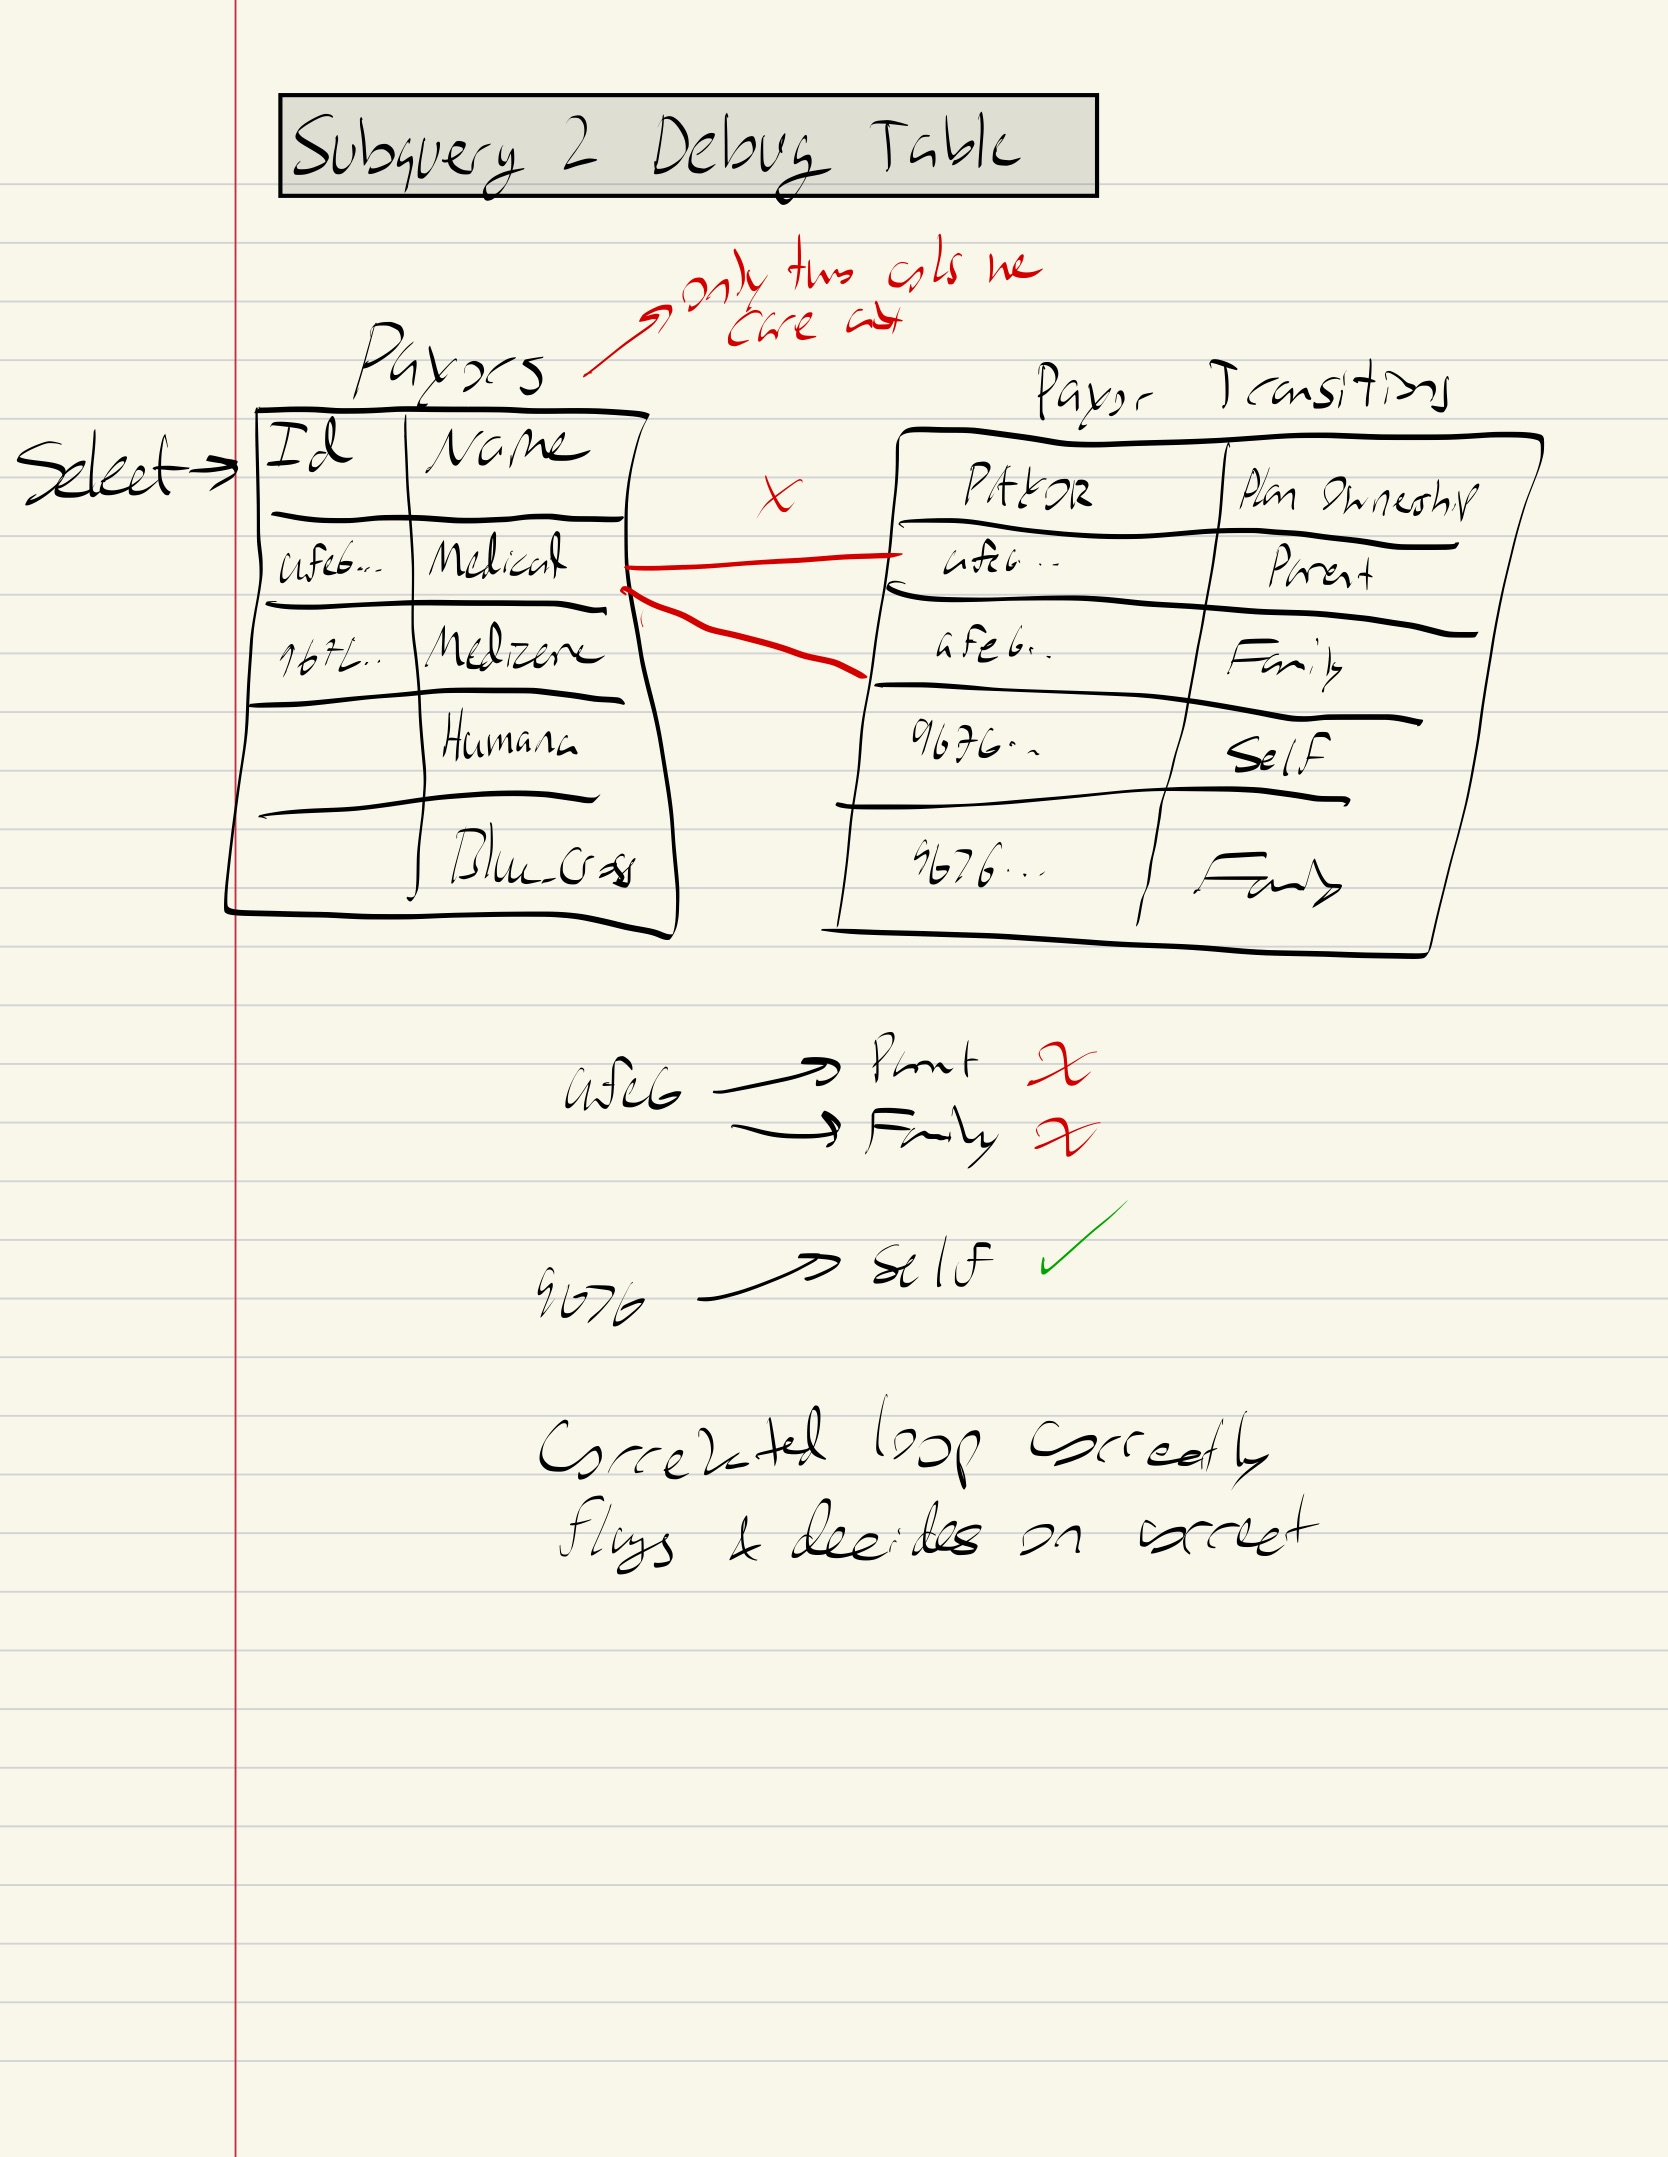)

## CTEs

Below we have included two CTEs, 2 queries with `WITH` clauses

### CTE 1:


###### **TITLE** : Male Medcaid New Yorkers
###### **DESC** : This query selects out all male new yorkers who are currently on medicaid.


In [54]:
query = f"""
WITH male_new_yorkers AS ( -- define male new yorkers table first
  SELECT p.Id as patient_id, p.FIRST, p.MIDDLE, p.LAST, p.STATE, p.GENDER
  FROM `{PROJECT_ID}.{DATASET_ID}.patients_ext` p
  WHERE (
    p.GENDER = 'M'
      AND
    p.STATE = 'New York'
  )
),
male_medicaid_ny AS ( -- select the mmedicaid patients from the male new yorkers table
  SELECT mny.patient_id, mny.FIRST, mny.MIDDLE, mny.LAST,  mny.STATE, mny.GENDER, p.NAME as insurer_name
  FROM male_new_yorkers mny
  LEFT JOIN `{PROJECT_ID}.{DATASET_ID}.payer_transitions_ext` pt on mny.patient_id = pt.PATIENT
  LEFT JOIN `{PROJECT_ID}.{DATASET_ID}.payers_ext` p on pt.PAYER = p.Id
  WHERE p.NAME = 'Medicaid'
)
SELECT DISTINCT *
FROM male_medicaid_ny
"""
df = bq_client.query(query).to_dataframe()
display(df)

,patient_id,FIRST,MIDDLE,LAST,STATE,GENDER,insurer_name
0,30e02880-42cd-e6d8-3a17-c78a9fe8fc5f,Irvin970,Enoch803,Goyette777,New York,M,Medicaid
1,c552c29b-21d6-88a7-da33-6c391eba4a46,Ellis535,Danilo179,Olson653,New York,M,Medicaid
2,d1b92425-45da-0cc9-0c34-3989347111ea,Mose244,Ezra452,King743,New York,M,Medicaid
3,5d8b7af2-1c66-ff6c-cff9-dbdac595aada,Virgil85,Ryan260,Stoltenberg489,New York,M,Medicaid
4,dee82d76-77d9-112d-6bdc-f7183e52dc1b,Arturo47,None,Schmitt836,New York,M,Medicaid
...,...,...,...,...,...,...,...
321,96854dfe-367f-7911-a84b-806fe5bd02d9,Jordon466,Von197,Bode78,New York,M,Medicaid
322,b1862ba4-3354-4bb8-2f56-7dcde12cb611,Napoleon578,Reggie481,Turner526,New York,M,Medicaid
323,01ce5297-4143-1e88-a520-3c793a1b9ee3,Emory494,None,Will178,New York,M,Medicaid
324,4f641b5a-7852-065a-e052-5c4504ea9ea0,Courtney281,Sol312,Lindgren255,New York,M,Medicaid


**CTE 1 DEBUG TABLE**

![[CS145] Projects-3.jpg](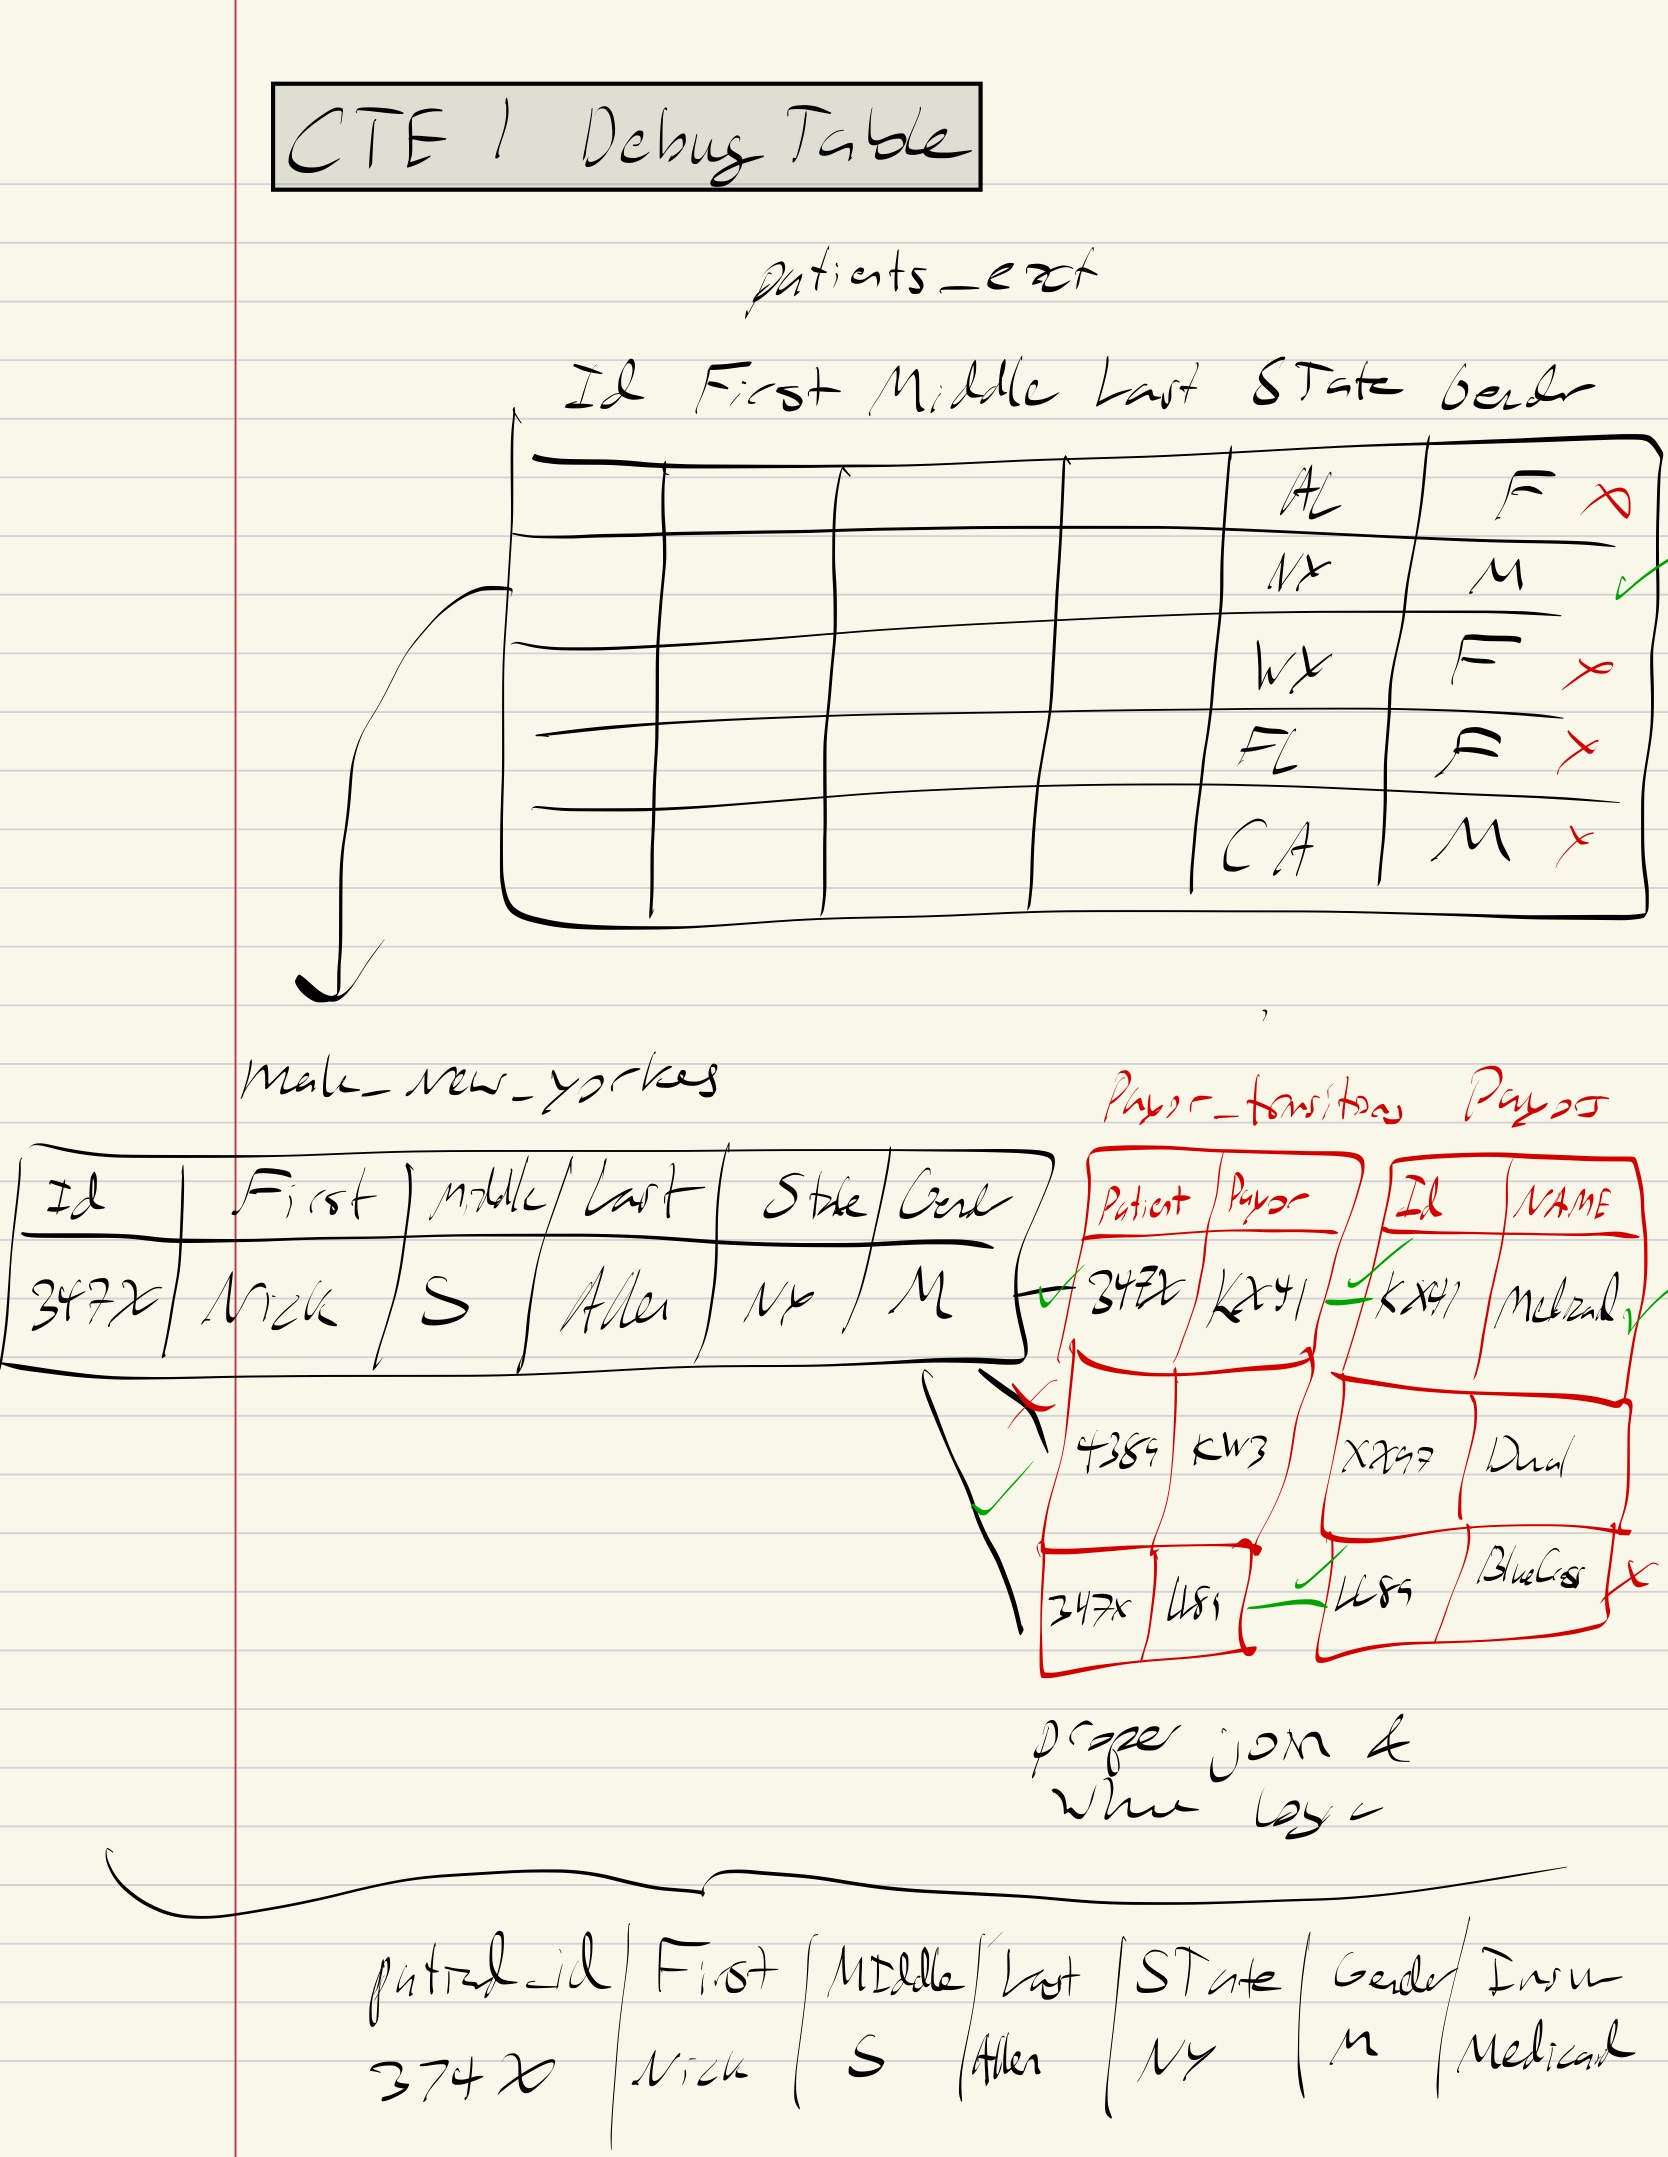)

### CTE 2:


Select vital sign observations that are above 150 dollar interactions

###### **TITLE** : Expensive Vital Encounters
###### **DESC** : This query find all vital sign encounters where the base price for the encounter was above 150 dollars.

In [55]:
query = f"""
WITH vital_sign_encounters AS ( -- define the vital sign encounter table
  SELECT o.ENCOUNTER, o.PATIENT, o.CATEGORY, o.DESCRIPTION
  FROM `{PROJECT_ID}.{DATASET_ID}.observations_ext` o
  WHERE
    o.CATEGORY = 'vital-signs'
),
expensive_vital_sign_encounters AS ( -- define the expensive encounter table
  SELECT vse.ENCOUNTER, vse.PATIENT, vse.CATEGORY, vse.DESCRIPTION, ee.BASE_ENCOUNTER_COST
  FROM vital_sign_encounters vse
  INNER JOIN `{PROJECT_ID}.{DATASET_ID}.encounters_ext` ee ON vse.ENCOUNTER = ee.Id
  WHERE ee.BASE_ENCOUNTER_COST > 150
)
SELECT DISTINCT vse.DESCRIPTION, vse.BASE_ENCOUNTER_COST -- select out the expensive encounters
FROM expensive_vital_sign_encounters vse
"""
df = bq_client.query(query).to_dataframe()
display(df)

,DESCRIPTION,BASE_ENCOUNTER_COST
0,Body Height,166.97
1,Body mass index (BMI) [Ratio],166.97
2,Diastolic Blood Pressure,166.97
3,Systolic Blood Pressure,171.97
4,Body Height,161.20
...,...,...
127,Body Weight,165.00
128,Body mass index (BMI) [Percentile] Per age and...,165.00
129,Head Occipital-frontal circumference Percentile,165.00
130,Head Occipital-frontal circumference,165.00


## Window Functions

Below I include 3 queries with OVER, PARTITION BY, and find differences between RANK vs ROW_NUMBER.

### Window Function 1:


###### **TITLE** : Ranked encounter classes
###### **DESC** : This query ranks encounter classes by their decreasing total claims cost and the row count by increasing total claims cost. We take both the rank and row_number so we can see the number of rows that we have between each group versus the number of ties we have within. We additionally order row number by description to visualize how many different descriptions of the same encounter type we hae in a row.


In [56]:
query = f"""
SELECT e.PATIENT, e.PROVIDER, e.PAYER, e.DESCRIPTION, e.TOTAL_CLAIM_COST, e.ENCOUNTERCLASS,
  RANK() OVER (
    PARTITION BY e.ENCOUNTERCLASS
    ORDER BY e.TOTAL_CLAIM_COST DESC
  ) AS Rank,
  ROW_NUMBER() OVER (
    PARTITION BY e.ENCOUNTERCLASS
    ORDER BY e.TOTAL_CLAIM_COST, e.DESCRIPTION DESC
  ) AS RowNumber
  FROM `{PROJECT_ID}.{DATASET_ID}.encounters_ext` e
"""
df = bq_client.query(query).to_dataframe()
display(df)

,PATIENT,PROVIDER,PAYER,DESCRIPTION,TOTAL_CLAIM_COST,ENCOUNTERCLASS,Rank,RowNumber
0,8ff9adc0-083b-59b3-ecc8-0289a0af7da2,40404f52-d125-3434-a41b-6aeee9e84652,a735bf55-83e9-331a-899d-a82a60b9f60c,Telephone encounter (procedure),75.00,virtual,6537,13
1,8ff9adc0-083b-59b3-ecc8-0289a0af7da2,40404f52-d125-3434-a41b-6aeee9e84652,a735bf55-83e9-331a-899d-a82a60b9f60c,Telephone encounter (procedure),75.00,virtual,6537,25
2,8ff9adc0-083b-59b3-ecc8-0289a0af7da2,40404f52-d125-3434-a41b-6aeee9e84652,a735bf55-83e9-331a-899d-a82a60b9f60c,Telephone encounter (procedure),75.00,virtual,6537,37
3,8ff9adc0-083b-59b3-ecc8-0289a0af7da2,40404f52-d125-3434-a41b-6aeee9e84652,a735bf55-83e9-331a-899d-a82a60b9f60c,Telephone encounter (procedure),75.00,virtual,6537,41
4,8ff9adc0-083b-59b3-ecc8-0289a0af7da2,40404f52-d125-3434-a41b-6aeee9e84652,a735bf55-83e9-331a-899d-a82a60b9f60c,Telephone encounter (procedure),75.00,virtual,6537,64
...,...,...,...,...,...,...,...,...
4850443,574e1bde-b364-77ce-f48b-5615f2ddfb03,6ecc456c-2e00-3ee8-b329-1f6a40e2e486,a735bf55-83e9-331a-899d-a82a60b9f60c,Ophthalmic examination and evaluation (procedure),2533.73,ambulatory,709291,2111671
4850444,4fe7407b-2306-51e1-5962-ae76c43b9f91,60d8b938-a5e1-3af1-a30d-3335445d63c0,d18ef2e6-ef40-324c-be54-34a5ee865625,Ophthalmic examination and evaluation (procedure),2533.73,ambulatory,709291,2111681
4850445,56b58493-bc9c-9c49-2f41-88a27ad65c87,e97b6840-2e53-3653-9481-9082b4469b75,a735bf55-83e9-331a-899d-a82a60b9f60c,Ophthalmic examination and evaluation (procedure),2533.73,ambulatory,709291,2111689
4850446,f74ad4f1-b5c9-b3e6-91d1-f1697d3b7ff1,9123bc46-c9ab-3034-a9e6-101d1d7ebcb5,d18ef2e6-ef40-324c-be54-34a5ee865625,Ophthalmic examination and evaluation (procedure),2533.73,ambulatory,709291,2111709


### Window Function 2:


###### **TITLE** : Ranked Insurer Coverage
###### **DESC** : This query joins payer records to patient coverage history to attribute each payer to a patient’s state, then computes each payer’s average covered amount per covered encounter. It aggregates by (STATE, payer_name), and ranks payers within each state by that average. The result highlights the top-performing payers per state on coverage generosity.

In [57]:
query = f"""
WITH payer_stats AS ( -- define payer stats table and get state
  SELECT
    pt.STATE,
    p.NAME AS payer_name,
    SAFE_DIVIDE(
      SUM(p.AMOUNT_COVERED),
      SUM(p.COVERED_ENCOUNTERS)
    ) AS avg_covered_amount
  FROM `{PROJECT_ID}.{DATASET_ID}.payers_ext` AS p
  LEFT JOIN `{PROJECT_ID}.{DATASET_ID}.payer_transitions_ext` AS pat
    ON p.Id = pat.PAYER
  LEFT JOIN `{PROJECT_ID}.{DATASET_ID}.patients_ext` AS pt -- need to traverse to patients to get state
    ON pt.Id = pat.PATIENT
  WHERE p.AMOUNT_COVERED > 0 -- filter out unwanted scenarios
    AND p.COVERED_ENCOUNTERS > 0
    AND p.NAME != "NO_INSURANCE"
  GROUP BY pt.STATE, payer_name
)
SELECT
  STATE,
  payer_name,
  avg_covered_amount,
  RANK() OVER ( -- select out and rank from the table we wanted
    PARTITION BY STATE ORDER BY avg_covered_amount DESC
    ) AS rank_in_state
FROM payer_stats
ORDER BY STATE, rank_in_state;
"""
df = bq_client.query(query).to_dataframe()
display(df)


,STATE,payer_name,avg_covered_amount,rank_in_state
0,Alabama,Blue Cross Blue Shield,7162.836326,1
1,Alabama,Medicaid,3497.175749,2
2,Alabama,UnitedHealthcare,2852.268467,3
3,Alabama,Dual Eligible,2772.178830,4
4,Alabama,Anthem,2634.106091,5
...,...,...,...,...
391,Wyoming,Anthem,2634.106091,5
392,Wyoming,Humana,2368.560622,6
393,Wyoming,Medicare,2263.546586,7
394,Wyoming,Cigna Health,2186.830716,8


### Window Function 3:


###### **TITLE** : Ranked Base Cost
###### **DESC** : Ranking the given base cost depending on the reason description

In [58]:
query = f"""
SELECT m.REASONDESCRIPTION, m.DESCRIPTION, m.BASE_COST,
RANK() OVER (
  PARTITION BY m.REASONDESCRIPTION -- create partition by reason description
  ORDER BY m.BASE_COST DESC
) AS rank
FROM `{PROJECT_ID}.{DATASET_ID}.medications_ext` m
WHERE -- only include entries where non null and exists base cost
  m.REASONDESCRIPTION IS NOT NULL
  AND
  m.DESCRIPTION IS NOT NULL
  AND
  m.BASE_COST > 0
ORDER BY m.BASE_COST DESC
"""
df = bq_client.query(query).to_dataframe()
display(df)

,REASONDESCRIPTION,DESCRIPTION,BASE_COST,rank
0,Alzheimer's disease (disorder),Tacrine 10 MG Oral Capsule,62289.00,1
1,Diabetes mellitus type 2 (disorder),3 ML liraglutide 6 MG/ML Pen Injector,61368.00,1
2,Diabetes mellitus type 2 (disorder),3 ML liraglutide 6 MG/ML Pen Injector,59912.76,2
3,Diabetes mellitus type 2 (disorder),3 ML liraglutide 6 MG/ML Pen Injector,59386.60,3
4,Diabetes mellitus type 2 (disorder),3 ML liraglutide 6 MG/ML Pen Injector,57631.67,4
...,...,...,...,...
5222584,Infection caused by Pseudomonas aeruginosa (di...,20 ML Ciprofloxacin 10 MG/ML Injection,0.01,1
5222585,Disease caused by severe acute respiratory syn...,Losartan Potassium 25 MG Oral Tablet,0.01,441
5222586,Disease caused by severe acute respiratory syn...,Losartan Potassium 25 MG Oral Tablet,0.01,441
5222587,Infection caused by Pseudomonas aeruginosa (di...,20 ML Ciprofloxacin 10 MG/ML Injection,0.01,1


# Section 4: Exploring Central Questions

## Question 1: ***Identify the best insurers for each state via average encounter duration and price paid for each state.***

In [59]:
query = f"""
WITH encounters_with_duration AS ( -- get duration of each encounter in minutes
  SELECT
    p.STATE,
    e.PAYER AS insurer,
    TIMESTAMP_DIFF(
      e.STOP,
      e.START,
      MINUTE
    ) AS duration_min
  FROM `{PROJECT_ID}.{DATASET_ID}.encounters_ext` e
  JOIN `{PROJECT_ID}.{DATASET_ID}.patients_ext`  p -- many to one, wont blow up
    ON p.Id = e.PATIENT
  WHERE
    e.START IS NOT NULL
    AND e.STOP IS NOT NULL
    AND e.STOP > e.START
),
avg_by_state_insurer AS ( -- get avg duration of each encounter by state and insurer
  SELECT
    STATE,
    insurer,
    AVG(duration_min) AS avg_duration_min,
    COUNT(*) AS n_encounters
  FROM encounters_with_duration
  GROUP BY STATE, insurer
),
ranked_avg_by_state_insurer AS ( -- rank the duration of each encounter
  SELECT
    STATE,
    insurer,
    avg_duration_min,
    n_encounters,
    RANK() OVER (
      PARTITION BY STATE
      ORDER BY avg_duration_min DESC
      ) as rank_num
  FROM avg_by_state_insurer
)
SELECT DISTINCT -- select out the top ranking, merging in the givne payer name
  rabsi.STATE,
  p.NAME AS payer_name,
  rabsi.avg_duration_min,
  rabsi.n_encounters,
  rabsi.rank_num
FROM ranked_avg_by_state_insurer rabsi
LEFT JOIN `{PROJECT_ID}.{DATASET_ID}.payers_ext` p
  ON rabsi.insurer = p.Id
WHERE rabsi.rank_num = 1
ORDER BY rabsi.avg_duration_min DESC
"""
avg_by_state_insurer = bq_client.query(query).to_dataframe()
display(avg_by_state_insurer)

,STATE,payer_name,avg_duration_min,n_encounters,rank_num
0,Mississippi,Dual Eligible,972.860169,236,1
1,Wyoming,Blue Cross Blue Shield,949.411765,17,1
2,California,Dual Eligible,854.836842,8740,1
3,Pennsylvania,Dual Eligible,789.061476,11907,1
4,South Dakota,Medicare,782.166349,65525,1
5,Florida,Medicare,777.397151,78630,1
6,Rhode Island,Dual Eligible,726.224123,14318,1
7,Illinois,Dual Eligible,707.676220,8095,1
8,Utah,Dual Eligible,701.707246,10572,1
9,Virginia,Dual Eligible,651.508719,11641,1


For the 40 / 50 states that are in the dataset, this analysis tells you what payors in the healthcare system merit the greatest amount of time spent with a given patient normalized by state

This analysis is irrespective of cost, lets also bring in the most expensive insurer by state with a similar query in order to see what might be the best insurance to actually get by weighing these two factors

In [60]:
query = f"""
WITH encounters_prices AS ( -- get price of each encounter
  SELECT e.PATIENT, e.TOTAL_CLAIM_COST, pay.NAME
  FROM `{PROJECT_ID}.{DATASET_ID}.encounters_ext` e
  LEFT JOIN `{PROJECT_ID}.{DATASET_ID}.payers_ext` pay
    ON e.PAYER = pay.Id
),
encounters_price_by_state AS ( -- get price of each encounter by state
  SELECT e.PATIENT, e.TOTAL_CLAIM_COST, e.NAME, p.STATE
  FROM encounters_prices e
  LEFT JOIN `{PROJECT_ID}.{DATASET_ID}.patients_ext` p
    ON e.PATIENT = p.Id
),
state_insurer_price AS ( -- get avg price of each insurer by state
  SELECT
    STATE,
    NAME,
    AVG(TOTAL_CLAIM_COST) AS avg_price
  FROM encounters_price_by_state
  WHERE NAME IS NOT NULL AND NAME != "NO_INSURANCE" -- filter out no insurance
  GROUP BY STATE, NAME
),
rank_state_insurer_price AS ( -- rank the price of each insurer by state
  SELECT
    STATE,
    NAME,
    avg_price,
    RANK() OVER
     (
      PARTITION BY STATE ORDER BY avg_price ASC -- rank by lowest price
      ) as rank_num
  FROM state_insurer_price
)
SELECT DISTINCT -- select out the top ranking, merging in the givne payer name
  rspi.STATE,
  rspi.NAME,
  rspi.avg_price,
  rspi.rank_num
FROM rank_state_insurer_price rspi
WHERE rspi.rank_num = 1
ORDER BY rspi.avg_price ASC
"""
best_price_by_insurance = bq_client.query(query).to_dataframe()
display(best_price_by_insurance)

,STATE,NAME,avg_price,rank_num
0,Wyoming,Medicaid,1131.872857,1
1,Alabama,Dual Eligible,1490.108212,1
2,Vermont,Medicaid,1795.811867,1
3,North Carolina,Blue Cross Blue Shield,1846.164257,1
4,Kentucky,Dual Eligible,1864.827665,1
5,North Dakota,UnitedHealthcare,1873.793961,1
6,Georgia,Aetna,1930.756464,1
7,Ohio,UnitedHealthcare,1979.322222,1
8,Arkansas,Blue Cross Blue Shield,2011.151838,1
9,Oklahoma,Aetna,2013.683658,1


#### Question 1 analysis: I use two queries to profile insurer “value” by state along time and cost. The first computes average encounter duration (START→STOP) per state–insurer and ranks within state; the second computes average total claim cost per state–insurer (excluding NO_INSURANCE) and ranks within state by lowest price. I noticed several large states represented (e.g., CA, TX, NY, FL) with clear spread across insurers—durations clustered in the tens of minutes and prices in the low-thousands of dollars, highlighting trade-offs between longer visits and lower costs. We can spot outliers by reviewing the full lists. People living in a given state can look at these two scores to see what insurer may be best for them. Down the line, I could then engineer a composite score that blends normalized cost and duration within each state (e.g., value_score = w₁·(−z_cost) + w₂·(−z_duration)) to produce a single, interpretable ranking of the “best” insurer per state. At first glance, we see that Wyoming may score very high on this.

## Question 2: ***Compare the average number of encounters per patient and the average base encounter cost per patient across income classes (Low, Mid, High)***

In [61]:
query = f"""
WITH stratified_patients AS ( -- get income class
  SELECT
    p.Id,
    p.INCOME AS income,
    CASE
      WHEN p.INCOME <  80000  THEN 'Low Income'
      WHEN p.INCOME <= 250000 THEN 'Mid Income'
      WHEN p.INCOME >  250000 THEN 'High Income'
      ELSE 'Unknown'
    END AS income_class
  FROM `{PROJECT_ID}.{DATASET_ID}.patients_ext` AS p
),
encounters_by_patient AS (
  -- one row per patient with their encounter count
  SELECT
    sp.income_class,
    sp.Id AS patient_id,
    sp.income,
    COUNT(e.Id) AS encounter_count -- total count of encounters
  FROM stratified_patients sp
  LEFT JOIN `{PROJECT_ID}.{DATASET_ID}.encounters_ext` e -- get encounters
    ON e.PATIENT = sp.Id
  GROUP BY sp.income_class, sp.Id, sp.income
),
class_norm AS (
  -- aggregate to income class and normalize
  SELECT
    income_class,
    COUNT(*) AS patient_count,
    SUM(encounter_count) AS total_encounters,
    -- getting average per patient for encounters
    SAFE_DIVIDE(SUM(encounter_count), COUNT(*)) AS avg_encounters_per_patient
  FROM encounters_by_patient
  GROUP BY income_class
)
SELECT
  income_class,
  patient_count,
  total_encounters,
  avg_encounters_per_patient
FROM class_norm
ORDER BY
  CASE income_class
    WHEN 'Low Income' THEN 1
    WHEN 'Mid Income' THEN 2
    WHEN 'High Income' THEN 3
    ELSE 4
  END;

"""
df = bq_client.query(query).to_dataframe()
display(df)

,income_class,patient_count,total_encounters,avg_encounters_per_patient
0,Low Income,42051,3401862,80.898480
1,Mid Income,16609,1245400,74.983443
2,High Income,2548,203186,79.743328


In [62]:
query = f"""
WITH stratified_patients AS ( -- get income class stratified
  SELECT
    p.Id,
    p.INCOME AS income,
    CASE
      WHEN p.INCOME <  80000  THEN 'Low Income'
      WHEN p.INCOME <= 250000 THEN 'Mid Income'
      WHEN p.INCOME >  250000 THEN 'High Income'
      ELSE 'Unknown'
    END AS income_class
  FROM `{PROJECT_ID}.{DATASET_ID}.patients_ext` AS p
),
price_by_patients AS (
  -- one row per patient with their encounter count
  SELECT
    sp.income_class,
    sp.Id AS patient_id,
    sp.income,
    SUM(e.BASE_ENCOUNTER_COST) AS sum_base_encounter_cost
  FROM stratified_patients sp
  LEFT JOIN `{PROJECT_ID}.{DATASET_ID}.encounters_ext` e
    ON e.PATIENT = sp.Id
  GROUP BY sp.income_class, sp.Id, sp.income
),
class_income_normed AS (
  -- aggregate to income class and normalize to number of patients
  SELECT
    income_class,
    COUNT(*) AS patient_count,
    SAFE_DIVIDE(SUM(sum_base_encounter_cost), COUNT(*)) AS avg_base_price_per_patient
  FROM price_by_patients
  GROUP BY income_class
)
SELECT
  income_class,
  patient_count,
  avg_base_price_per_patient
FROM class_income_normed
ORDER BY
  CASE income_class
    WHEN 'Low Income' THEN 1
    WHEN 'Mid Income' THEN 2
    WHEN 'High Income' THEN 3
    ELSE 4
  END;

"""
df = bq_client.query(query).to_dataframe()
display(df)

,income_class,patient_count,avg_base_price_per_patient
0,Low Income,42051,7478.717056
1,Mid Income,16609,7057.538988
2,High Income,2548,7590.136464


Across income tiers, I normalized utilization and cost per patient. Low-income patients (42k) average 80.9 encounters/patient with 7,479 avg base cost/patient. Mid-income (16.6k) are lowest on both with 75.0 encounters and $7,058; high-income (2.5k) show 79.7 encounters and 7,590. This pattern implies mid-income patients are the least intensive and least costly per patient, while low- and high-income cohorts are more intensive with comparable or higher baseline cost.

From these insights, we might audit high-income utilization for low-value care. This would include reviewing rates and adjusting guidelines.

We might also target avoidable utilization in low-income cohorts. W could expand care coordination, transportation vouchers, and screening; pushing telehealth and nurse triage to divert throughput visits.

## Question 3: Measure the 30-day revisit rate across provider-state combinations

In [63]:
query = f"""-- 30-day revisit rate by (STATE, insurer)
WITH enc_start AS (
  SELECT
    e.Id,
    e.PATIENT,
    e.START AS start_ts,
    e.PAYER,
    e.PROVIDER
  FROM `{PROJECT_ID}.{DATASET_ID}.encounters_ext` e
  WHERE e.START IS NOT NULL
),
enc_with_next AS (
  SELECT
    Id,
    PATIENT,
    PAYER,
    start_ts,
    PROVIDER,
    LEAD(start_ts) OVER ( -- Find the next encounter per patients, 1 row look forward
      PARTITION BY PATIENT ORDER BY start_ts -- order by start time for a given patient
      ) AS next_start_ts
  FROM enc_start
),
flag_30d AS (
  SELECT
    x.PATIENT,
    x.PAYER,
    x.PROVIDER, -- will use this later to join in provider
    -- index encounter, the encounter that we will look forward from
    x.start_ts AS index_start,
    -- find if there has been a revist in the past 30 days
    IF(
      x.next_start_ts IS NOT NULL
      AND TIMESTAMP_DIFF(x.next_start_ts, x.start_ts, DAY) <= 30,
      1, 0
    ) AS revisit_30d -- revists flag
  FROM enc_with_next x
),
with_state_provider AS (
  SELECT
    p.STATE,
    prov.NAME AS provider,
    f.revisit_30d
  FROM flag_30d f
  JOIN `{PROJECT_ID}.{DATASET_ID}.patients_ext` p
    ON p.Id = f.PATIENT
  LEFT JOIN `{PROJECT_ID}.{DATASET_ID}.providers_ext` prov
    ON prov.Id = f.PROVIDER
  WHERE prov.NAME IS NOT NULL and f.revisit_30d IS NOT NULL
),
with_state_provider_rate as(
SELECT
  STATE,
  provider,
  COUNT(*) AS index_encounters,
  SUM(revisit_30d) AS revisits_within_30d,
  SAFE_DIVIDE(SUM(revisit_30d), COUNT(*)) AS revisit_rate_30d
FROM with_state_provider
GROUP BY STATE, provider
HAVING COUNT(*) > 10 -- filter out small groups that cause noise
),
with_ranked_revist_rate as(
SELECT
  STATE,
  provider,
  index_encounters,
  revisits_within_30d,
  revisit_rate_30d,
  RANK () OVER (
    PARTITION BY STATE
    ORDER BY revisit_rate_30d ASC, index_encounters ASC
  ) as revist_rate_rank,
  FROM with_state_provider_rate
)
SELECT *
FROM with_ranked_revist_rate
ORDER BY revisit_rate_30d DESC, index_encounters DESC;
"""

df = bq_client.query(query).to_dataframe()
display(df)

,STATE,provider,index_encounters,revisits_within_30d,revisit_rate_30d,revist_rate_rank
0,California,Leonel449 Goldner995,150,150,1.0,1300
1,Virginia,Antoine384 Maggio310,128,128,1.0,634
2,California,Son314 Kshlerin58,124,124,1.0,1299
3,North Carolina,Donny470 Runte676,90,90,1.0,816
4,Montana,Douglas31 Kuhlman484,81,81,1.0,330
...,...,...,...,...,...,...
24645,Florida,Tanika746 Baumbach677,11,0,0.0,1
24646,Pennsylvania,Margarita164 Abbott774,11,0,0.0,1
24647,New Hampshire,Paz9 Gerlach374,11,0,0.0,1
24648,New Mexico,Fidel864 Swift555,11,0,0.0,1


This pipeline computes a per-provider, per-state 30-day revisit rate by. Practically, this surfaces providers with unusually high revisit rates in a given state—prime targets for interventions. As such, this query shows many potential action items:

*   Create stronger discharge instructions
*   Scheduled follow-ups before discharge and telehealth check-ins at 3–7 days.
*   Care-management outreach for chronic conditions.  
*   Drill into top revisit diagnoses, and compares outcomes pre/post interventions.
*    We could tie contracting or quality incentives to reductions in revisit_rate_30d and require corrective plans where rates exceed a certain margin





# Section 5: Takeaways

---
**Summary of what I learned:**
Using synthetic Synthea data, I profiled insurer “value” by state along two axes—time (avg encounter duration) and cost (avg claim price)—and found clear trade-offs across states, suggesting opportunities to balance throughput and spend. By income tier, I normalized to the patient level and saw that mid-income patients had the lowest average encounters per patient and lowest base cost per patient, while low- and high-income groups were more intensive with comparable or higher per-patient costs. Finally, I measured 30-day revisit rates by provider–state, using LEAD() to identify next visits, which highlighted providers with unusually high revisit rates—actionable targets for discharge planning, early follow-ups, and care-management outreach. These cuts collectively point to a practical scoring framework that could combine normalized cost, time, and revisit rate into a single, state-specific value index for patients and payers. The upshot would be to enable patients with state wise data that could help them pick the best plans. I learned a ton about debugging SQL queries, how to write robust winodw, CTE, rank functions and more. This tangible practice really cemented my SQL knowledge.

**Limitations of Analysis:**
My results are not risk-adjusted (no severity/diagnosis mix, age, or ENCOUNTERCLASS stratification) and may reflect case-mix and access differences rather than pure performance. I am hoping the averages over groups smoothed some of this out, however it definetly effected my results. Moreover, Synthetic data can encode generator biases and lacks real-world contracting effects. Small cells (etc high-income, or reecounter count) reduce stability despite minimum-n filters. Metrics focus on process/utilization (duration, counts, revisits) rather than clinical outcomes. This is only going to be correlated with clinical outcomes - clinical outcomes are hard to process due to the narrative and natural language involved to capture them.

**How you used AI to brainstorm questions and approach:** For the approach portion, I actually did not use AI. My career focuses on AI / Computational approached to healthcare, and I have spent a long time in this space. As such i knoew I wanted to use AI and leverage synthetic data. For the questions, I give ChatGPT the schemas and allow it to brainstorm 20 different possible questions after providing the framework. I actually did not end up using any of those questions (the queries would have ended up convoluted), but this was helpful for getting me to think about the potential questions to ask.

**How you used AI as training wheels:**
My approach to querying was as follows: I would start by deciding what shape of query (CTEs, Windows, etc.) and what specific tables I would need from my 8 possible choices. I would then write out the logic behind the query. I would ask Chat if this was the right approach or if I should restructure (all still while in pseduocode land). I actually gave Chat a system prompt to not return any pseduocode, just steer me in the right direction. Next, I would take my attempt at writing the query with actual syntax, iteratively running as I build out the query. When I got an error, I tried to solve for myself. If it took a substantial amount of time, I palce the query into chat and asked it to identify the SQL syntax erorr. This to be was the best approach to learning the material while not wasting pointless time get stuck with syntax that I had not had the time to full digest

**How you verified SQL correctness with debug tables:** The part I learned about debug tables was where to start. For subqueries, I started with the inner query. For CTEs, I started at the top. I then made a small sample table and ensured that my logic carried through as I worked through the process of my queries to ensure that I was getting the result I desired.

---